In [1]:
#!/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.5.4/bin/python

import netCDF4 as nc4
import numpy as np
from simpledbf import Dbf5
import time
import pandas as pd
import os
import xarray as xr

secprday = 3600*24


In [2]:
# select reservoir name
reservoir_name = 'Waterton' # possible to replace by: Dickson, Bhumiboi, Waterton, Glen_canyon, Palisades, Trinity, Semione, Sirikit
#reservoir_name = "Bhumiboi"
#reservoir_name = "Sirikit"
#reservoir_name = 'Waterton'

In [3]:
# Load data from Yassin et al 2019
metadata = pd.read_csv('observations/reservoirs_metadata.csv')
metadata.index = metadata['name']

# get the information
purpose = metadata.loc[reservoir_name].purpose
max_storage = metadata.loc[reservoir_name].capacity_mcm*10**6


# load observations
fn = 'observations/res_info_out_'+reservoir_name+'.csv'
df = pd.read_csv(fn)
df.index = pd.to_datetime(df.timed)

time_unit_nc = "days since "+str(pd.to_datetime(df.timed.iloc[0]))
print(time_unit_nc)

outflow_obs = df['outflow']
storage_obs = df['stoobs']; storage_inital = storage_obs[0]; print(storage_inital)
inflow = df['inflow']

# average inflow (Hanasaki uses naturalised inflow)
# tbd how to do in MizuRoute (e.g. log mean monthly inflow inflow of last 20 or 5 years, e.g. Droppers et al., 2020)

# here taken as mean over whole observational period
mean_inflow = inflow.mean() # (m³/s)

mean_inflow_monthly = inflow.groupby([inflow.index.month]).mean() # to adjust for seasonal cycle (m³/s)
print(mean_inflow_monthly)

# 
demand_irrig_monthly = np.zeros(12) # [m³/s] 

if reservoir_name == "Bhumiboi": demand_irrig_monthly = np.array([0,150,200,250,200,75,50,50,20,0,30,0])
if reservoir_name == "Sirikit" : demand_irrig_monthly = np.array([0,50,100,200,100,50,20,50,10,10,0,0])
if reservoir_name == "Waterton": demand_irrig_monthly = np.array([0,0,5,30,50,50,30,20,5,0,0,0]) # estimated demand (to test demand > inflow * erf)


# total annual inflow
mean_inflow_yearly = mean_inflow_monthly.mean() # m³/s
 
c = max_storage/(mean_inflow_yearly * secprday * 365) #[m³/yr] # if c>0.5 : large reservoir, if c < 0.5: "whitin-a-year" reservoir, if c = 0, reservoir is "run-of-the-river"

print('reservoir = '+reservoir_name)
print("purpose = "+purpose)
print("c = %.2f" %c)
print("mean annual inflow = %.0f m³/s" %mean_inflow_yearly)
print("mean annual inflow = %.0f m³" %max_storage)
print("mean annual inflow = %.0f m³" %storage_inital)


days since 2000-01-01 00:00:00
117947285.668
timed
1      4.773612
2      3.992379
3      4.875873
4     12.443187
5     57.310746
6     93.045493
7     36.323431
8     11.863176
9      8.495772
10     8.444174
11     9.388514
12     5.353412
Name: inflow, dtype: float64
reservoir = Waterton
purpose = irrigation
c = 0.26
mean annual inflow = 21 m³/s
mean annual inflow = 172700000 m³
mean annual inflow = 117947286 m³


In [4]:
# load the date frame and create the netwrok topology
Ntopo = pd.read_csv('look_up/NetTopo.csv')
Ntopo_flags = pd.read_csv('look_up/NetTopo_flags.csv')


Ntopo.name.iloc[1] =  reservoir_name
Ntopo.H06_Smax     =  max_storage
Ntopo.H06_S_ini    =  storage_inital
Ntopo.name.iloc[1] =  reservoir_name
Ntopo.H06_I_Jan    =  mean_inflow_monthly.iloc[0]
Ntopo.H06_I_Feb    =  mean_inflow_monthly.iloc[1]
Ntopo.H06_I_Mar    =  mean_inflow_monthly.iloc[2]
Ntopo.H06_I_Apr    =  mean_inflow_monthly.iloc[3]
Ntopo.H06_I_May    =  mean_inflow_monthly.iloc[4]
Ntopo.H06_I_Jun    =  mean_inflow_monthly.iloc[5]
Ntopo.H06_I_Jul    =  mean_inflow_monthly.iloc[6]
Ntopo.H06_I_Aug    =  mean_inflow_monthly.iloc[7]
Ntopo.H06_I_Sep    =  mean_inflow_monthly.iloc[8]
Ntopo.H06_I_Oct    =  mean_inflow_monthly.iloc[9]
Ntopo.H06_I_Nov    =  mean_inflow_monthly.iloc[10]
Ntopo.H06_I_Dec    =  mean_inflow_monthly.iloc[11]
Ntopo.H06_D_Jan    =  demand_irrig_monthly[0]
Ntopo.H06_D_Feb    =  demand_irrig_monthly[1]
Ntopo.H06_D_Mar    =  demand_irrig_monthly[2]
Ntopo.H06_D_Apr    =  demand_irrig_monthly[3]
Ntopo.H06_D_May    =  demand_irrig_monthly[4]
Ntopo.H06_D_Jun    =  demand_irrig_monthly[5]
Ntopo.H06_D_Jul    =  demand_irrig_monthly[6]
Ntopo.H06_D_Aug    =  demand_irrig_monthly[7]
Ntopo.H06_D_Sep    =  demand_irrig_monthly[8]
Ntopo.H06_D_Oct    =  demand_irrig_monthly[9]
Ntopo.H06_D_Nov    =  demand_irrig_monthly[10]
Ntopo.H06_D_Dec    =  demand_irrig_monthly[11]

if purpose == "irrigation":
    Ntopo.purpose.iloc[1] = 1
else:
    Ntopo.purpose.iloc[1] = 0

Ntopo.to_csv('network_topology/NetTopo_'+reservoir_name+'.csv')


/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [5]:
def nc_creation(Ntopo, Ntopo_flags, reservoir_name):
    
    # remove sxisting files
    if os.path.isfile('./network_topology/network_topology_'+reservoir_name+'.nc'):
        os.remove('./network_topology/network_topology_'+reservoir_name+'.nc')

    # open the nc file to write
    ncid = nc4.Dataset('./network_topology/network_topology_'+reservoir_name+'.nc', "w", format="NETCDF4")

    # the dimension of the nc file variables is equal to the row of the shapefile
    dimid_N = ncid.createDimension('n',Ntopo.shape[0])
    dimid_Nchar = ncid.createDimension('nchar',4)

    # going through the field one by one and saving them in nc varibales with long name, units and variable type (int, etc)
    for column in list(Ntopo_flags.columns):
        
        print(column, Ntopo_flags[column].iloc[0], Ntopo_flags[column].iloc[1], Ntopo_flags[column].iloc[2])
        
        # define the variable
        varid = ncid.createVariable(column, Ntopo_flags[column].iloc[0],('n',),\
                                    zlib=True,fill_value=Ntopo_flags[column].iloc[2]) #assuming all the fields are floats
        # Attributes
        varid.long_name      = column
        varid.unit           = Ntopo_flags[column].iloc[1]

        # Write data
        varid[:] = Ntopo[column]
    
    
    # define the variable PFAF
    varid = ncid.createVariable('PFAF','S1',('n','nchar',)) #assuming all the fields are floats
    # Attributes
    varid.long_name      = 'PFAF Order'
    varid.unit           = '-'
    # preparing the data
    data = np.full(Ntopo.shape[0], 'test', 'S4')
    data = nc4.stringtochar(data)
    varid[:,:]=data

    ncid.Conventions = 'CF-1.6'
    ncid.License     = 'The data were written by Shervan Gharari. They are under GPL.'
    ncid.history     = 'Created ' + time.ctime(time.time())
    ncid.source      = 'Written by test script of utilities (https://github.com/ShervanGharari/utility-codes).'
    ncid.close()


# 
nc_creation(Ntopo, Ntopo_flags, reservoir_name)





is_lake int - -1
lake_model int - -1
purpose int - -1
basin_area f8 m**2 -9999
length f8 m -9999
slope f8 - -9999
lon f8 - -9999
lat f8 - -9999
hruid int - -1
seg_id int - -1
seg_hr_id int - -1
tosegment int - -1
width f8 m -9999
manning f8 - -9999
H06_irrigation int - -1
H06_Smax f8 m**3 -9999
H06_alpha f8 - -9999
H06_envfact f8 - -9999
H06_S_ini f8 m**3 -9999
H06_C1 f8 - -9999
H06_C2 f8 - -9999
H06_power f8 - -9999
H06_dinominator f8 - -9999
H06_c_compare f8 - -9999
H06_dead_S_Per f8 - -9999
H06_I_Mem_F int - -1
H06_I_Mem_L int - -1
H06_D_Mem_F int - -1
H06_D_Mem_L int - -1
H06_I_Jan f8 m**3 s**-1 -9999
H06_I_Feb f8 m**3 s**-1 -9999
H06_I_Mar f8 m**3 s**-1 -9999
H06_I_Apr f8 m**3 s**-1 -9999
H06_I_May f8 m**3 s**-1 -9999
H06_I_Jun f8 m**3 s**-1 -9999
H06_I_Jul f8 m**3 s**-1 -9999
H06_I_Aug f8 m**3 s**-1 -9999
H06_I_Sep f8 m**3 s**-1 -9999
H06_I_Oct f8 m**3 s**-1 -9999
H06_I_Nov f8 m**3 s**-1 -9999
H06_I_Dec f8 m**3 s**-1 -9999
H06_D_Jan f8 m**3 s**-1 -9999
H06_D_Feb f8 m**3 s**-1 -99

In [6]:
# create the input file for mizuRoute for a network topology of size 3

n_dim_length = 3
n_dim_time   = len(inflow)

print(n_dim_time, n_dim_length)

time_data = np.arange(n_dim_time)


values = np.zeros((n_dim_time, n_dim_length))
values[:,0] = inflow
print(values)


temp = pd.read_csv('network_topology/NetTopo_'+reservoir_name+'.csv')
basin_area = temp.basin_area.iloc[1]


if os.path.isfile('./network_topology/input_'+reservoir_name+'.nc'):
    os.remove('./network_topology/input_'+reservoir_name+'.nc')

with nc4.Dataset('./network_topology/input_'+reservoir_name+'.nc', "w", format="NETCDF4") as ncid:

    dimid_N = ncid.createDimension('n', n_dim_length)  # only write one variable
    dimid_T = ncid.createDimension('time', n_dim_time)

    # Variables
    time_varid = ncid.createVariable('time', 'i4', ('time', ))
    # Attributes
    time_varid.long_name = 'time'
    time_varid.units = time_unit_nc  # e.g. 'days since 1900-01-01 00:00'
    time_varid.calendar = 'gregorian'
    time_varid.standard_name = 'time'
    time_varid.axis = 'T'
    # Write data
    time_varid[:] = time_data

    # Variables
    ID_varid = ncid.createVariable('ID', 'int', ('n', ))
    # Attributes
    ID_varid.long_name = 'ID'
    ID_varid.units = '1'
    # Write data
    ID_varid[:] = np.array([1,2,3])

    # Variable
    # data_varid = ncid.createVariable(variable_name, 'f8', ('n','time', ), fill_value=-9999)
    data_varid = ncid.createVariable('runoff', 'f8', ('time','n', ), fill_value=-9999)
    # Attributes
    data_varid.long_name = 'runoff'
    data_varid.units = 'm day**-1'
    # Write data
    data_varid[:]   = values * secprday/ basin_area
    
    # Variable
    # data_varid = ncid.createVariable(variable_name, 'f8', ('n','time', ), fill_value=-9999)
    data_varid = ncid.createVariable('evapo', 'f8', ('time','n', ), fill_value=-9999)
    # Attributes
    data_varid.long_name = 'Evaporation'
    data_varid.units = 'mm day**-1'
    # Write data
    data_varid[:] = 0
    
    # Variable
    # data_varid = ncid.createVariable(variable_name, 'f8', ('n','time', ), fill_value=-9999)
    data_varid = ncid.createVariable('precip', 'f8', ('time','n', ), fill_value=-9999)
    # Attributes
    data_varid.long_name = 'preipitation'
    data_varid.units = 'mm day**-1'
    # Write data
    data_varid[:] = 0

    ##
    ncid.Conventions = 'CF-1.6'
    ncid.License = 'The data were written by Shervan Gharari. Under Apache2.'
    ncid.history = 'Created ' + time.ctime(time.time())
    ncid.source = 'Written by script from library of Shervan Gharari (https://github.com/ShervanGharari/candex).'



4383 3
[[5.8453 0.     0.    ]
 [5.6997 0.     0.    ]
 [5.7773 0.     0.    ]
 ...
 [4.4577 0.     0.    ]
 [4.302  0.     0.    ]
 [3.9878 0.     0.    ]]


[[0.00505034 0.         0.        ]
 [0.00492454 0.         0.        ]
 [0.00499159 0.         0.        ]
 ...
 [0.00385145 0.         0.        ]
 [0.00371693 0.         0.        ]
 [0.00344546 0.         0.        ]]


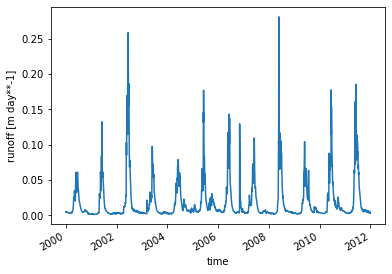

In [12]:
ds = xr.open_dataset('./network_topology/input_'+reservoir_name+'.nc')
ds.runoff[:,0].plot()
print(np.array(ds.runoff[:]))



In [68]:
print(len(inflow), len(outflow_obs))

4383 4383
